In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
import numpy as np
import torch.nn.functional as F
from math import exp
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import math
import time
import torch.nn.utils as utils
from matplotlib import container

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array- value.data.numpy())).argmin()
    return idx

In [3]:
def query(action,func):
    y_out=[]
    x_out=[]
    for i in range(action.size(0)):
        idx=find_nearest(xs,action[i])
        y=func[i][idx]
        x_out.extend([xs[idx]])
        y_out.extend([y])
    x_out=np.array(x_out).reshape(action.size(0),1)
    x_out=torch.from_numpy(x_out[:])
    y_out=np.array(y_out).reshape(action.size(0),1)
    y_out=torch.from_numpy(y_out[:,:])
    input=torch.cat((x_out,y_out),1)
    return input,x_out,y_out

In [4]:
def query_mf(action,func,func_mf,fidelity):
    y_out=[]
    x_out=[] 
    for i in range(action.size(0)):
        if fidelity[i] ==0.:
            idx=find_nearest(xs_mf,action[i])
            y=func_mf[i][idx]
            x_out.extend([xs_mf[idx]])
        else :
            idx=find_nearest(xs,action[i])
            y=func[i][idx]
            x_out.extend([xs[idx]])
        y_out.extend([y])
    x_out=np.array(x_out).reshape(action.size(0),1)
    x_out=torch.from_numpy(x_out[:]).double()
    y_out=np.array(y_out).reshape(action.size(0),1)
    y_out=torch.from_numpy(y_out[:,:]).double()
    input=torch.cat((x_out,y_out),1)
    return input,x_out,y_out

In [5]:
def process(x0,func):
    inputs=[]
    x_out=[]
    y_out=[]
    idx=find_nearest(xs,x0)
    for i in range(func.size(0)):
        y=func[i][idx]
        x_out.extend([xs[idx]])
        y_out.extend([y])
    x_out=np.array(x_out).reshape(func.size(0),1)
    x_out=torch.from_numpy(x_out[:])
    y_out=np.array(y_out).reshape(func.size(0),1)
    y_out=torch.from_numpy(y_out[:,:])
    input=torch.cat((x_out,y_out),1)
    return input

In [6]:
np.random.seed(77)
torch.manual_seed(77)
    
#starting point
x0=torch.tensor([0.0])
step=20
future=0

hidden_size=64
sigma=0.1
n=2000

testing_loss=[]

xs = np.arange(-1.0, 1.0, 0.01)
xs_mf = np.arange(-1.0, 1.0, 0.02)
func = torch.load('testdata_7000.pt')
func_mf = torch.load('testdata_7000_fidelity2.pt')
func=np.array(func)
func_mf=np.array(func_mf)


In [7]:
class Sequence_mf(nn.Module):
    def __init__(self):
        super(Sequence_mf, self).__init__()
        self.lstm1 = nn.LSTMCell(2,64)
        self.lstm2 = nn.LSTMCell(1,64)
        self.linear1= nn.Linear(64,1)
        self.linear2= nn.Linear(64,1)
        self.tanh=nn.Tanh()
        self.sigmoid=nn.Sigmoid()
        
    def forward(self,input,func,func_mf,sigma,future=0):
        outputs = []
        log_probs = []
        rewards = []
        entropies = []
        actions = []
        fidelity_all=[]
        time_step=[]
        
        h_t = torch.zeros(input.size(0), 64, requires_grad=False, dtype=torch.double).cuda()
        c_t = torch.zeros(input.size(0), 64, requires_grad=False, dtype=torch.double).cuda()
        
        h2_t = torch.zeros(input.size(0), 64, requires_grad=False, dtype=torch.double).cuda()
        c2_t = torch.zeros(input.size(0), 64, requires_grad=False, dtype=torch.double).cuda()
        
        outputs += [input]
        t0 = time.time()
        for i in range(step+future):
            h_t, c_t = self.lstm1(input, (h_t, c_t))
            h_t=h_t.detach()
            c_t=c_t.detach()
            mean=self.linear1(h_t)
            mean=self.tanh(mean)
            m = torch.distributions.normal.Normal(mean,sigma)
            action=m.sample()
            entropy=m.entropy()
            
            h2_t, c2_t = self.lstm2(action, (h2_t, c2_t))
            h2_t=h2_t.detach()
            c2_t=c2_t.detach()
            prob=self.linear2(h2_t)
            prob=self.sigmoid(prob)
            w = torch.distributions.bernoulli.Bernoulli(prob)
            
            fidelity=w.sample()
            
            #next input
            
            input,action_new,reward=query_mf(action.cpu(),func,func_mf,fidelity.cpu())
            log_prob=m.log_prob(action_new.cuda())
           
            input=input.cuda()
            outputs += [input]
            
            log_probs.append(log_prob)
            rewards.append(reward)
            entropies.append(entropy)
            actions.append(action_new)
            fidelity_all.append(fidelity.double())
            t1=time.time() - t0
            time_step.append(t1)
            
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs,log_probs,rewards,entropies,actions,fidelity_all,time_step

In [8]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(2,hidden_size)
        self.linear1= nn.Linear(hidden_size,1)
        self.linear2= nn.Linear(hidden_size,1)
        self.tanh=nn.Tanh()
        
    def forward(self,input,func,sigma,future=0):
        outputs = []
        log_probs = []
        rewards = []
        entropies = []
        actions = []
        time_step=[]
        
        h_t = torch.zeros(input.size(0), hidden_size, requires_grad=False, dtype=torch.double).cuda()
        c_t = torch.zeros(input.size(0), hidden_size, requires_grad=False, dtype=torch.double).cuda()
        outputs += [input]
        t0 = time.time()
        for i in range(step+future):
            
            h_t, c_t = self.lstm1(input, (h_t, c_t))
            h_t=h_t.detach()
            c_t=c_t.detach()
            mean=self.linear1(h_t)
            mean=self.tanh(mean)
            #print('mean:',mean.detach().cpu().numpy())
            m = torch.distributions.normal.Normal(mean,sigma)
            action=m.sample()
            entropy=m.entropy()
            
            
            input,action_new,reward=query(action.cpu(),func)
            #print('action:',action_new)
            log_prob=m.log_prob(action_new.cuda())
            input=input.cuda()
            outputs += [input]
            
            log_probs.append(log_prob)
            rewards.append(reward)
            entropies.append(entropy)
            actions.append(action_new)
            t1=time.time() - t0
            time_step.append(t1)
            
            
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs,log_probs,rewards,entropies,actions,time_step

In [9]:
def min_found(rewards):
        min_step=[]    
        min=rewards[0].clone()
        for i in range(len(rewards)):
                if rewards[i]<min:
                    min=rewards[i]
                min_step.append(min)
        return min_step,min

In [10]:
def mins_found(rewards):
        min_step=[]    
        min_h=rewards[0].clone()
        for i in range(len(rewards)):
            for j in range(rewards[i].size(0)):
                if rewards[i][j]<min_h[j]:
                    min_h[j]=rewards[i][j]
            min_step.append(min_h.mean())
        return min_step

In [11]:
def min_loss(rewards):
        min_step=[]    
        min_h=rewards[0].clone()
        for i in range(len(rewards)):
            for j in range(rewards[i].size(0)):
                if rewards[i][j]<min_h[j]:
                    min_h[j]=rewards[i][j]
            min_step.append(min_h.clone())            
        return min_step

In [12]:
f=0
future=0
sigma=0.1
func_test = torch.from_numpy(func[f:f+2000,:])
func_test_mf = torch.from_numpy(func_mf[f:f+2000, :])
input_test=process(x0,func_test)
input_test=input_test.cuda()

In [13]:
#OI
seq1 = Sequence().cuda()
seq1.double()
seq1.load_state_dict(torch.load('seq37_100.pkl')) #37


In [14]:
#SUM
seq2 = Sequence().cuda()
seq2.double()
seq2.load_state_dict(torch.load('seq31_100.pkl')) #31

In [15]:
#MIN
seq3 = Sequence().cuda()
seq3.double()
seq3.load_state_dict(torch.load('seq40_100.pkl')) #40


In [16]:
#OI
t0 = time.time()
with torch.no_grad():
        out_test,log_probs,test_rewards,entropies,test_actions,time_step = seq1(input_test,func_test,sigma,future)
        t1=time.time() - t0
        min_step=mins_found(test_rewards)
        min_result=min_loss(test_rewards)
        std=[]
        for i in range(len(test_rewards)):
            std.append((((min_result[i]**2).sum() /len(test_rewards[0])-(min_result[i].mean())**2 )/len(test_rewards[0]))**0.5)
        y = out_test.cpu().detach().numpy()
print('time : {:.02e} seconds'.format(t1))


time : 5.60e-01 seconds


In [17]:
#SUM
t0 = time.time()
with torch.no_grad():
        out_test,log_probs,test_rewards,entropies,test_actions,time_step2 = seq2(input_test,func_test,sigma,future)
        t2=time.time() - t0
        min_step2=mins_found(test_rewards)
        min_result=min_loss(test_rewards)
        std2=[]
        for i in range(len(test_rewards)):
            std2.append((((min_result[i]**2).sum() /len(test_rewards[0])-(min_result[i].mean())**2 )/len(test_rewards[0]))**0.5)
        y = out_test.cpu().detach().numpy()
print('time : {:.02e} seconds'.format(t2))

time : 5.47e-01 seconds


In [18]:
#MIN
t0 = time.time()
with torch.no_grad():
        out_test,log_probs,test_rewards,entropies,test_actions,time_step3 = seq3(input_test,func_test,sigma,future)
        t3=time.time() - t0
        min_step3=mins_found(test_rewards)
        min_result=min_loss(test_rewards)
        std3=[]
        for i in range(len(test_rewards)):
            std3.append((((min_result[i]**2).sum() /len(test_rewards[0])-(min_result[i].mean())**2 )/len(test_rewards[0]))**0.5)
        y = out_test.cpu().detach().numpy()
print('time : {:.02e} seconds'.format(t3))


time : 5.55e-01 seconds


In [19]:
#mf
seq4 = Sequence_mf().cuda()
seq4.double()
seq4.load_state_dict(torch.load('seq73_100.pkl')) #sum 78 #min 62 #oi 73

In [20]:
t0 = time.time()
with torch.no_grad():
            out_test,log_probs,test_rewards,entropies,test_actions,fidelity,time_step4 = seq4(input_test,func_test,func_test_mf,sigma,future)
            t4=time.time() - t0
            min_step6=mins_found(test_rewards)
            min_result=min_loss(test_rewards)
            std6=[]
            for i in range(len(test_rewards)):
                std6.append((((min_result[i]**2).sum() /len(test_rewards[0])-(min_result[i].mean())**2 )/len(test_rewards[0]))**0.5)
            y = out_test.cpu().detach().numpy()
print('time : {:.02e} seconds'.format(t4))

time : 7.46e-01 seconds


In [21]:
#rand
from random import randint
steps=step+future
min_step_rand=[0]*steps
sumxx2_rand=[0]*steps
idx=[]
num=2000
for f in range(num):

    min=1
    for i in range(steps):
        idx_next=randint(0,199)
        idx.append(idx_next)
        if func[f][idx_next]<min:
            min =func[f][idx_next]
        min_step_rand[i]+=min
        sumxx2_rand[i]+=min**2
        
std_rand=[]        
for i in range(steps):
    std_rand.append(((sumxx2_rand[i]/num-(min_step_rand[i]/num)**2)/num)**0.5)
for i in range(steps):
    min_step_rand[i]/=num
    

In [22]:
#rand_mf
min_step_rand_mf=[0]*steps
idx=[]
#fidelity_rand=[]
num=100
for f in range(num):

    min=1
    for i in range(steps):
        fidelity_next=randint(0,1)
        if fidelity_next == 0 :
            idx_next=randint(0,199)
            if func[f][idx_next]<min:
                min =func[f][idx_next]
        else :
            idx_next=randint(0,99)
            if func_mf[f][idx_next]<min:
                min =func_mf[f][idx_next]
        #fidelity_rand.append(fidelity_next)   
        idx.append(idx_next)
        
        
        min_step_rand_mf[i]+=min

for i in range(steps):
    min_step_rand_mf[i]/=num

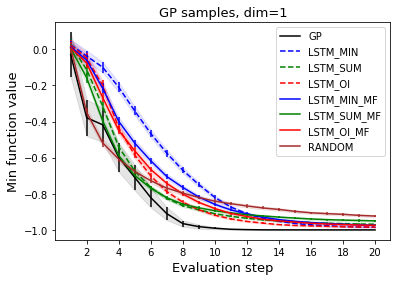

In [24]:
steps=np.arange(1,step+future+1, 1)

plt.xticks(np.arange(0, step+future+2, 2))

plt.fill_between(steps, min_step_gp-std_gp*2, min_step_gp+std_gp*2,color="black", alpha=0.1)
plt.fill_between(steps, np.asarray(min_step5)-np.asarray(std5)*2, np.asarray(min_step5)+np.asarray(std5)*2,color="blue", alpha=0.1)
plt.fill_between(steps, np.asarray(min_step4)-np.asarray(std4)*2, np.asarray(min_step4)+np.asarray(std4)*2,color="green", alpha=0.1)
plt.fill_between(steps, np.asarray(min_step3)-np.asarray(std3)*2, np.asarray(min_step3)+np.asarray(std3)*2,color="blue", alpha=0.1) 
plt.fill_between(steps, np.asarray(min_step2)-np.asarray(std2)*2, np.asarray(min_step2)+np.asarray(std2)*2,color="green", alpha=0.1) 
plt.fill_between(steps, np.asarray(min_step)-np.asarray(std)*2, np.asarray(min_step)+np.asarray(std)*2,color="red", alpha=0.1)
plt.fill_between(steps, np.asarray(min_step6)-np.asarray(std6)*2, np.asarray(min_step6)+np.asarray(std6)*2,color="red", alpha=0.1) 
plt.fill_between(steps, min_step_rand-np.asarray(std_rand)*2, min_step_rand+np.asarray(std_rand)*2,color="brown", alpha=0.1)


plt.errorbar(steps,min_step_gp, np.asarray(std_gp)*2,color='black',linestyle='-',linewidth=1.5,label='GP')
plt.errorbar(steps,min_step3, np.asarray(std3)*2,color='blue',linestyle='--',linewidth=1.5,label='LSTM_MIN')
plt.errorbar(steps,min_step2, np.asarray(std2)*2,color='green',linestyle='--',linewidth=1.5,label='LSTM_SUM')
plt.errorbar(steps,min_step, np.asarray(std)*2,color='red',linestyle='--',linewidth=1.5,label='LSTM_OI')
plt.errorbar(steps,min_step5, np.asarray(std5)*2,color='blue',linestyle='-',linewidth=1.5,label='LSTM_MIN_MF')
plt.errorbar(steps,min_step4, np.asarray(std4)*2,color='green',linestyle='-',linewidth=1.5,label='LSTM_SUM_MF')
plt.errorbar(steps,min_step6, np.asarray(std6)*2,color='red',linestyle='-',linewidth=1.5,label='LSTM_OI_MF')
plt.errorbar(steps,min_step_rand, np.asarray(std_rand)*2,color='brown',linestyle='-',linewidth=1.5,label='RANDOM')

#remove errorbar in legend
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] if isinstance(h,container.ErrorbarContainer) else h for h in handles]

plt.legend(handles, labels,loc='upper right')
#plt.legend(handles, labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Min function value',size=13) 
plt.xlabel('Evaluation step',size=13) 
plt.title('GP samples, dim=1',size=13)
#plt.savefig("min_step_1.pdf", bbox_inches="tight")
plt.show()


In [25]:
#np.save('min_step_oi_mf.npy',np.array(min_step6))
#np.save('std_oi_mf.npy',np.array(std6))

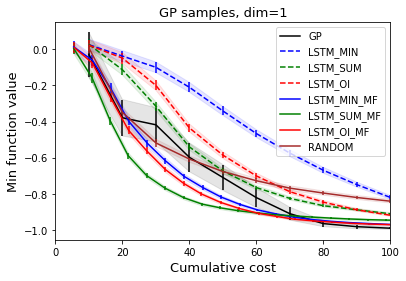

In [27]:
cost=0.
cost_all=[]
cost_sf = np.arange(10, 205, 10)
for i in range(len(fidelity)):
    cost += (fidelity[i]*9+1).sum()/len(fidelity[i])
    cost_all.append(cost.clone())
plt.fill_between(cost_sf, min_step_gp-std_gp*2, min_step_gp+std_gp*2,color="black", alpha=0.1)
plt.fill_between(cost_min, np.asarray(min_step5)-np.asarray(std5)*2, np.asarray(min_step5)+np.asarray(std5)*2,color="blue", alpha=0.1)
plt.fill_between(cost_sum, np.asarray(min_step4)-np.asarray(std4)*2, np.asarray(min_step4)+np.asarray(std4)*2,color="green", alpha=0.1)
plt.fill_between(cost_sf, np.asarray(min_step3)-np.asarray(std3)*2, np.asarray(min_step3)+np.asarray(std3)*2,color="blue", alpha=0.1) 
plt.fill_between(cost_sf, np.asarray(min_step2)-np.asarray(std2)*2, np.asarray(min_step2)+np.asarray(std2)*2,color="green", alpha=0.1) 
plt.fill_between(cost_sf, np.asarray(min_step)-np.asarray(std)*2, np.asarray(min_step)+np.asarray(std)*2,color="red", alpha=0.1)
plt.fill_between(cost_oi, np.asarray(min_step6)-np.asarray(std6)*2, np.asarray(min_step6)+np.asarray(std6)*2,color="red", alpha=0.1) 
plt.fill_between(cost_sf, min_step_rand-np.asarray(std_rand)*2, min_step_rand+np.asarray(std_rand)*2,color="brown", alpha=0.1)


plt.errorbar(cost_sf,min_step_gp, np.asarray(std_gp)*2,color='black',linestyle='-',linewidth=1.5,label='GP')
plt.errorbar(cost_sf,min_step3, np.asarray(std3)*2,color='blue',linestyle='--',linewidth=1.5,label='LSTM_MIN')
plt.errorbar(cost_sf,min_step2, np.asarray(std2)*2,color='green',linestyle='--',linewidth=1.5,label='LSTM_SUM')
plt.errorbar(cost_sf,min_step, np.asarray(std)*2,color='red',linestyle='--',linewidth=1.5,label='LSTM_OI')
plt.errorbar(cost_min,min_step5, np.asarray(std5)*2,color='blue',linestyle='-',linewidth=1.5,label='LSTM_MIN_MF')
plt.errorbar(cost_sum,min_step4, np.asarray(std4)*2,color='green',linestyle='-',linewidth=1.5,label='LSTM_SUM_MF')
plt.errorbar(cost_oi,min_step6, np.asarray(std6)*2,color='red',linestyle='-',linewidth=1.5,label='LSTM_OI_MF')
plt.errorbar(cost_sf,min_step_rand, np.asarray(std_rand)*2,color='brown',linestyle='-',linewidth=1.5,label='RANDOM')

#remove errorbar in legend
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] if isinstance(h,container.ErrorbarContainer) else h for h in handles]

plt.legend(handles, labels,loc='upper right')
#ax.legend(handles, labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.ylabel('Min function value',size=13) 
plt.xlabel('Cumulative cost',size=13) 
plt.title('GP samples, dim=1',size=13)

plt.xlim(0,100)
#plt.savefig("min_cost_1.pdf",bbox_inches="tight")
plt.show()



In [28]:
#np.save('cost_oi_mf.npy',np.array(cost_all))

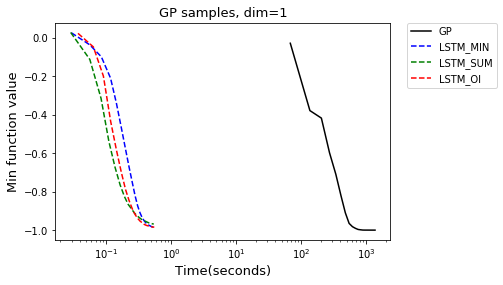

In [29]:
time_gp=1361
time_step_gp=[]
sum=0
for i in range(20):
    sum+=time_gp/20
    time_step_gp.append(sum)
plt.plot(time_step_gp,min_step_gp,'k',label='GP')
plt.plot(time_step3,min_step3,'b--',label='LSTM_MIN')
plt.plot(time_step2,min_step2,'g--',label='LSTM_SUM')
plt.plot(time_step,min_step,'r--',label='LSTM_OI')

#remove errorbar in legend
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] if isinstance(h,container.ErrorbarContainer) else h for h in handles]


ax.legend(handles, labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend(handles, labels,loc='upper right')
plt.title('GP samples, dim=1',size=13)
plt.ylabel('Min function value',size=13) 
plt.xlabel('Time(seconds)',size=13)

plt.xscale('log')
#plt.savefig("min_time_1.pdf",bbox_inches="tight")
plt.show()